In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy as sp
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data.dataloader import default_collate
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import math

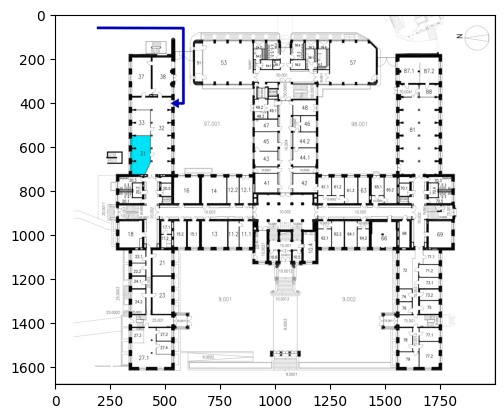

In [2]:
background = cv2.imread("data/cab_floor_0.png")
plt.imshow(background)

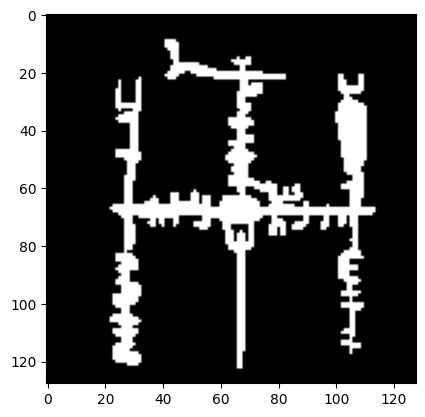

In [3]:
walk_mask = cv2.imread("data/cab_floor_0_walk.png")
walk_mask = np.logical_and(walk_mask[:,:,0] > 200, walk_mask[:,:,1] < 100)
walk_mask = cv2.resize(walk_mask.astype(np.float32), (128,128)).astype(bool)
(h,w) = walk_mask.shape 
    
plt.imshow(walk_mask, cmap='gray')

In [4]:
import rustworkx

In [5]:
graph = rustworkx.PyGraph()

nodes = [[]]
for i in range(walk_mask.shape[0]):
    nodes.append([])
    for j in range(walk_mask.shape[1]):
        if walk_mask[i,j]:
            nodes[i].append(graph.add_node((j,i)))
        else:
            nodes[i].append(None)
        
for i in range(walk_mask.shape[0]):
    for j in range(walk_mask.shape[1]):
        if not walk_mask[i][j]:
            continue
        if i>0 and walk_mask[i-1][j]:
            graph.add_edge(nodes[i-1][j], nodes[i][j], 1)
        if i<walk_mask.shape[0]-1 and walk_mask[i+1][j]:
            graph.add_edge(nodes[i+1][j], nodes[i][j], 1)
        if j>0 and walk_mask[i][j-1]:
            graph.add_edge(nodes[i][j-1], nodes[i][j], 1)
        if j<walk_mask.shape[1] and walk_mask[i][j+1]:
            graph.add_edge(nodes[i][j+1], nodes[i][j], 1)
            
nodes = np.array(graph.nodes())
print(nodes.shape)

(2286, 2)


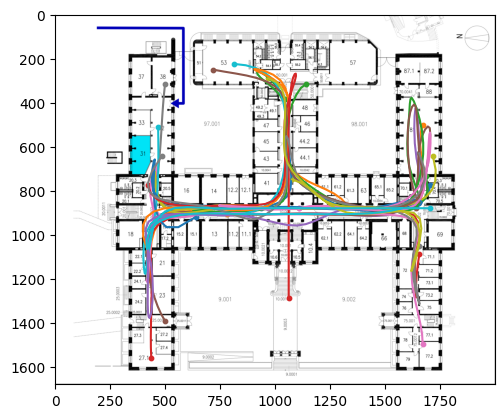

In [6]:
def gen_shortest_path(min_len, n_waypoints):
    assert n_waypoints >= 2
    
    while True:
        waypoints = np.random.choice(graph.node_indices(), size=n_waypoints)
        
        paths = []
        retry = False
        for i in range(n_waypoints-1):
            start,end = waypoints[i:i+2]
            path = rustworkx.dijkstra_shortest_paths(graph,start,end)
            if not end in path:
                retry = True
                break
            path = np.array(rustworkx.dijkstra_shortest_paths(graph,start,end)[end], dtype=int)
            paths.append(path[:-1])
        
        if retry:
            continue
        paths = np.concatenate(paths)
            
        if paths.shape[0] > min_len:
            return nodes[paths[:min_len]] / [w,h]
        
def smooth_path(path, keypoint_stride=16, interpolating_stride=4):
    n = path.shape[0]
    waypoints = path[::keypoint_stride, :]
    
    spline = sp.interpolate.make_interp_spline(x=np.linspace(0,n-1,len(waypoints)), y=waypoints)
    
    smooth = spline(np.linspace(0,n-1, n//interpolating_stride))
    return smooth
    
def plot_paths(img, path, endpoint_s=10):
    plt.imshow(img, cmap='gray')
    
    scaley, scalex = img.shape[0:2]
    
    if not isinstance(path,list):
        path = [path]
    
    for p in path:
        start,end = p[0,:], p[-1,:]
        plt.plot(p[:,0]*scalex, p[:,1]*scaley)  
        plt.scatter([scalex*start[0],scalex*end[0]], [scaley*start[1],scaley*end[1]], s=endpoint_s)

    
def gen_path(min_len, n_waypoints):
    path = gen_shortest_path(min_len, n_waypoints)
    path = smooth_path(path)
    return path


k = 20
min_len = 200
n_waypoints = 4
paths = []
for i in range(k):
    paths.append(gen_path(min_len, n_waypoints=n_waypoints))
    
plot_paths(background,paths)

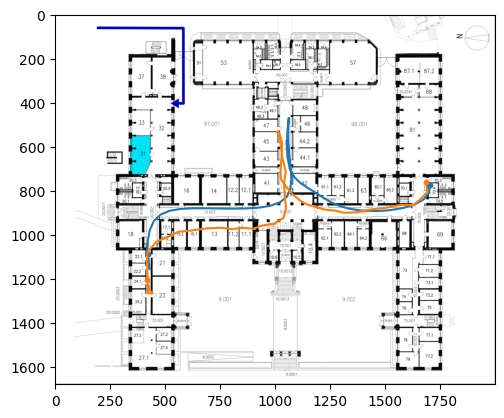

In [7]:
def add_noise_path(path, noise):
    n = path.shape[0]
    
    o = np.random.uniform(low=-noise, high=noise, size=(n,2))
    new_path = path + np.cumsum(o, axis=0)
    return new_path
    
noise = 10e-3

path = paths[0]
noisy_path = add_noise_path(path, noise)

plot_paths(background, [path, noisy_path])

In [8]:
class PathDataset(Dataset):
    def __init__(self, min_len, min_incorrect_dist, noise, n_waypoints, n_paths, n_correct_per_path, n_incorrect_per_path):
        paths = []
        for i in range(n_paths):
            path = gen_path(min_len, n_waypoints=n_waypoints)
            paths.append(path)
        
        noisy_paths = []
        for path in paths:
            noisy_paths.append([add_noise_path(path, noise=noise) for i in range(n_correct_per_path)])
        
        self.paths = []
        self.labels = []
        
        for i in range(n_paths):
            end = paths[i][-1]
            
            for path in noisy_paths[i]:
                self.paths.append((path + (end - path[-1,:])).astype(np.float32))
                self.labels.append((1.0, paths[i].astype(np.float32)))
            #continue
                
            exl_self = noisy_paths[:i-1] + noisy_paths[i+1:]
            
            def choose(p):
                return p[random.randint(0,len(p)-1)]
            
            for j in range(n_incorrect_per_path):
                while True:
                    sel_paths = choose(exl_self)                    
                    p = choose(choose(exl_self))
                    
                    if np.linalg.norm(p[-1] - end) < min_incorrect_dist:
                        continue
                    
                    p = p + (end - p[-1,:]) # make path end at location
                    self.paths.append(p.astype(np.float32))
                    self.labels.append((0.0, paths[i].astype(np.float32)))
                    break
                    
        #max_len = max(map(len, self.paths))
        #self.paths = [np.concatenate([p, np.zeros((max_len-p.shape[0],2))]).astype(np.float32) for p in paths]
        #print(max_len)
        print(self.paths[0].shape)
    
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        return self.paths[idx], self.labels[idx]

(25, 2)
(50, 2)


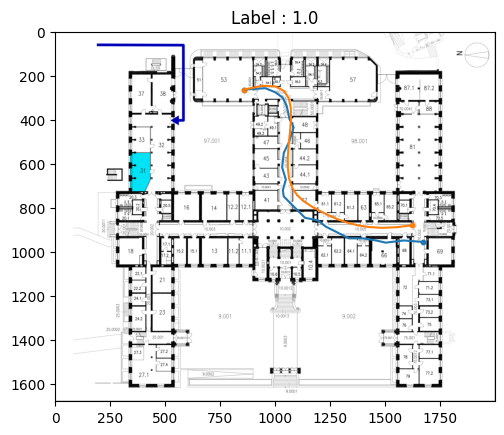

In [9]:
dataset = PathDataset(
    min_len = 100,
    n_waypoints=4,
    noise=1e-2,
    min_incorrect_dist=0.3,
    n_paths=10,
    n_correct_per_path=10,
    n_incorrect_per_path=10
)

print(gen_path(min_len=200, n_waypoints=4).shape)
path, (label,p2) = dataset[0]

plt.title("Label : " + str(label))
plot_paths(background, [path, p2])

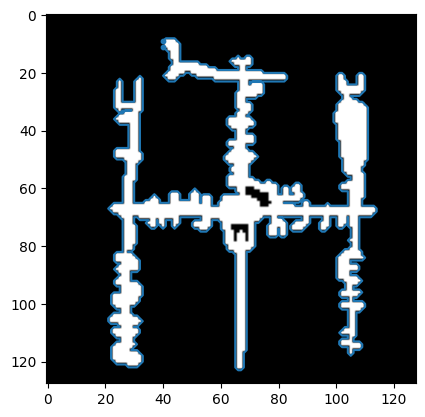

In [10]:
contours, _ = cv2.findContours(255 - 255*walk_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [c[:,0,:].astype(np.float32) / [w,h] for c in contours]
contours = contours[1] #np.concatenate(contours)
plot_paths(walk_mask, contours)
plt.imshow(walk_mask, cmap='gray')

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout: float = 0.1):
        super().__init__()
        #self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        assert d_model % 4 == 0, "Embedding dim must be divisble by 4"
        self.register_buffer('freq_term', torch.arange(1, d_model//4+1, 1))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        freq_term = self.freq_term
        
        result = torch.concatenate([
            torch.sin(np.pi*x[:,:,0].unsqueeze(2) * freq_term),
            torch.cos(np.pi*x[:,:,0].unsqueeze(2) * freq_term),
            torch.sin(np.pi*x[:,:,1].unsqueeze(2) * freq_term),
            torch.cos(np.pi*x[:,:,1].unsqueeze(2) * freq_term),
        ], dim=2)

        return result
        
seq = PositionalEncoding(4)
seq(1*torch.ones(size=(2,32,2)))  

"""nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 64),
    nn.ReLU()
)"""

'nn.Sequential(\n    nn.Linear(2, 8),\n    nn.ReLU(),\n    nn.Linear(8, 64),\n    nn.ReLU()\n)'

In [12]:
path,label = dataset[0]

In [79]:

class TransformerBlock(nn.Module):
    def __init__(self, embeds_size, drop_prob=0.1, num_heads=1): # (batch_size, block_size, embeds_size)
        super(TransformerBlock, self).__init__()
        self.embeds_size = embeds_size
        self.attention = nn.MultiheadAttention(embeds_size, 1, dropout=0, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embeds_size, 4*embeds_size),
            nn.LeakyReLU(),
            nn.Linear(4*embeds_size, embeds_size),
            nn.LeakyReLU(),
        )
        
        self.drop1 = nn.Dropout(drop_prob)
        self.drop2 = nn.Dropout(drop_prob)
        self.ln1 = nn.LayerNorm(embeds_size, eps=1e-6)
        self.ln2 = nn.LayerNorm(embeds_size, eps=1e-6)
        
    def forward(self, hidden_state, keys, values):
        assert hidden_state.shape[2] == self.embeds_size
        attn,_ = self.attention(hidden_state, keys, values)
        attn = self.drop1(attn)
        out = hidden_state + attn
        observed = self.ffn(out)
        observed = self.drop2(observed)
        result = out + observed
        return result
        
class SeqPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return self.dropout(x)


class PathClassifier(nn.Module):
    def __init__(self):
        super(PathClassifier, self).__init__()
        
        d_model = 8
        dropout = 0.000
        
        # #PositionalEncoding(d_model, dropout)
        self.encoder = PositionalEncoding(d_model, dropout)
        self.seq_encoder = SeqPositionalEncoding(d_model, dropout)
        
        self.transformer_layers = 4
        self.map_attention = nn.ModuleList([TransformerBlock(d_model,dropout) for i in range(self.transformer_layers+1)])
        self.self_attention = nn.ModuleList([TransformerBlock(2*d_model,dropout) for i in range(self.transformer_layers)])
        
        self.reduce = nn.Sequential(
            nn.Linear(16, 2),
            nn.ReLU()
        )
        
        self.cfn = nn.Sequential(
            nn.Linear(8, 1),
            nn.ReLU()
        )
        
        self.d_model = d_model
        
    def encode_map(self, map_contour):       
        y = self.encoder(map_contour.unsqueeze(0)).squeeze(0)
        return y

    def forward(self,x, map_embed):
        map_embed = map_embed.unsqueeze(0).repeat((x.shape[0],1,1))

        x = 255*x
        
        mask = x[:,0] != 0 
        
        d_model = self.d_model
        
        x = self.encoder(x)
        x1 = x #[:,:,:d_model]
        x2 = self.seq_encoder(x)
        x = torch.concatenate([x1, x2], dim=2)
        
        for i in range(self.transformer_layers):
            x1 = self.map_attention[i](x[:,:,:d_model],map_embed,map_embed)
            x2 = x[:,:,d_model:]
            x = torch.concatenate([x1, x2], dim=2)
            x = self.self_attention[i](x, x, x)
            
        y = self.reduce(x)
        
        z = self.map_attention[i+1](x[:,:,:d_model],map_embed,map_embed)
        z = self.cfn(z)
        z = torch.sum(z, dim=1)
        
        return z, torch.sigmoid(z.squeeze(1)), y

#torch.set_seed()
model = PathClassifier()
print(np.sum(path))

#model(torch.tensor([path],dtype=torch.float32), model.encode_map(torch.tensor(contours, dtype=torch.float32)))
model(torch.zeros((1,10,2)), model.encode_map(torch.zeros((10,2))))

24.676394


(tensor([[0.]], grad_fn=<SumBackward1>),
 tensor([0.5000], grad_fn=<SigmoidBackward0>),
 tensor([[[0.3059, 0.1695],
          [0.3242, 0.1736],
          [0.4417, 0.0000],
          [0.5568, 0.0000],
          [0.5573, 0.0000],
          [0.4259, 0.0000],
          [0.2842, 0.2368],
          [0.2615, 0.3180],
          [0.3468, 0.1527],
          [0.4668, 0.0000]]], grad_fn=<ReluBackward0>))

In [35]:
device = torch.device("mps:0")

In [39]:
dataset_training = PathDataset(
    min_len = 200,
    n_waypoints=4,
    noise=1e-2,
    min_incorrect_dist=0.3,
    n_paths=5000,
    n_correct_per_path=10,
    n_incorrect_per_path=10
)
dataset_test = PathDataset(
    min_len = 200,
    n_waypoints=4,
    noise=1e-2,
    min_incorrect_dist=0.3,
    n_paths=1000,
    n_correct_per_path=10,
    n_incorrect_per_path=10,
)

batch_size = 8

(50, 2)
(50, 2)


In [48]:
def collate(x):
    inps = []
    labels = []
    refs = []

    for inp, (label,ref) in x:
        inps.append(inp)
        labels.append(label)
        refs.append(ref)
        
    inp = np.stack(inps)
    labels = np.array(labels,dtype=np.float32)
    ref = np.stack(refs)
        
    return (torch.tensor(inp).to(device), (torch.tensor(labels).to(device), torch.tensor(ref).to(device)))

batch_size = 4
train_loader = torch.utils.data.DataLoader(dataset_training, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=collate)

In [49]:
x,(label,ref) = next(train_loader.__iter__())
print(x.shape, label, ref.shape)

torch.Size([4, 50, 2]) tensor([0., 1., 1., 1.], device='mps:0') torch.Size([4, 50, 2])


In [50]:
contours_device = torch.tensor(contours, dtype=torch.float32).to(device)

In [80]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    running_acc = 0
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        inputs, labels = data
        batch_size = inputs.shape[0]

        optimizer.zero_grad()

        map_embed = model.encode_map(contours_device)
        outputs = model(inputs, map_embed)
        
        loss = huber_loss(inputs,outputs[1]) #loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        # Gather data and report
        acc = ((outputs[0]>0.5)==(labels[0]>0.5)).sum().item()
        running_loss += loss.item()
        running_acc += acc
        if i % 50 == 49:
            last_loss = running_loss / 50 # loss per batch
            last_acc = running_acc / 50 / 16
            print((outputs[0]>0.5)==(labels[0]>0.5))
            print('  batch {} loss: {}, acc: {}, acc: {}/{}'.format(i + 1, last_loss, last_acc, acc, batch_size))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.add_scalar('Acc/train', last_acc, tb_x)
            running_loss = 0.
            running_acc = 0.

    return last_loss, last_acc

In [81]:
bce_loss = torch.nn.BCELoss()
huber_loss = torch.nn.HuberLoss(reduction='sum')

def loss_fn(pred, labels):
    label_pred, path_pred = pred
    label_ref, path_ref = labels
    
    return bce_loss(label_pred,label_ref) + 0.1*huber_loss(path_pred,path_ref)

In [82]:
# Initializing in a separate cell so we can easily add more epochs to the same run
model = PathClassifier().to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.03) 

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('data/runs/path_classifier')
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_acc  = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    running_vacc = 0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        map_encode = model.encode_map(contours_device)
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs, map_encode)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            running_vacc += ((voutputs[0]>0.5)==(vlabels[0]>0.5)).sum().item()

    test_batch_size = next(test_loader)[0].shape[0]
            
    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1) / test_batch_size
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training acc' : avg_acc, 'Validation acc' : avg_vacc},
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/Users/antonellacalvia/miniconda3/envs/eth_localization/lib/python3.11/site-packages/torch/nn/modules/loss.py:993: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 50, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 2

In [ ]:
""" path, label = PathDataset(
    min_len = 200,
    n_waypoints=4,
    noise=3e-2,
    min_incorrect_dist=0.3,
    n_paths=2,
    n_correct_per_path=10,
    n_incorrect_per_path=10
)[0]
"""

path,label = dataset_training[11]
pred_label,pred_path = model.to(device)(torch.tensor(path).to(device).unsqueeze(0), model.encode_map(contours_device))
pred_label = pred_label.item()
pred_path = pred_path.cpu().detach().numpy()

plt.title("Label : " + str(label[0]) + ", predicted:" + str(pred_label))
plot_paths(background, [path, pred_path])